In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import classification_report, precision_recall_curve, auc

# 1. Load Data
df = pd.read_csv('../data/processed/market_features.csv', index_col=0, parse_dates=True)

# 2. Create Target (Same as Week 7)
df['Next_Day_Return'] = df['SPY_Log_Ret'].shift(-1)
df['Target'] = (df['Next_Day_Return'] < -0.01).astype(int)
df = df.dropna()

# 3. Define Features
features = ['SPY_Log_Ret', 'SPY_Vol_30d'] 
X = df[features]
y = df['Target']

# 4. Time Series Split
# We define 5 splits. Each split takes a chunk of past data to predict the next chunk.
tscv = TimeSeriesSplit(n_splits=5)

print("Setup Complete. Ready for Boosting.")

Setup Complete. Ready for Boosting.


In [2]:
# 1. Define the Parameter Grid (The "Search Space")
param_dist = {
    'n_estimators': [50, 100, 200],        # How many trees?
    'learning_rate': [0.01, 0.05, 0.1],    # How fast to learn?
    'max_depth': [3, 4, 5, 6],             # How complex can a tree be?
    'scale_pos_weight': [1, 5, 10],        # Importance of the "Crash" class
    'subsample': [0.7, 0.8, 0.9]           # Fraction of data to use per tree
}

# 2. Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# 3. Setup Randomized Search
# n_iter=20 means "Try 20 random combinations"
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc', # We optimize for AUC (ability to distinguish classes)
    cv=tscv,           # STRICTLY use TimeSeriesSplit
    verbose=1,
    n_jobs=-1,         # Use all CPU cores
    random_state=42
)

# 4. Run the Search (This might take 30-60 seconds)
print("Starts Tuning...")
random_search.fit(X, y)

# 5. Get Best Results
print("------------------------------------------------")
print(f"Best ROC-AUC Score: {random_search.best_score_:.4f}")
print("Best Parameters:")
print(random_search.best_params_)
print("------------------------------------------------")

Starts Tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
------------------------------------------------
Best ROC-AUC Score: 0.5338
Best Parameters:
{'subsample': 0.7, 'scale_pos_weight': 5, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
------------------------------------------------


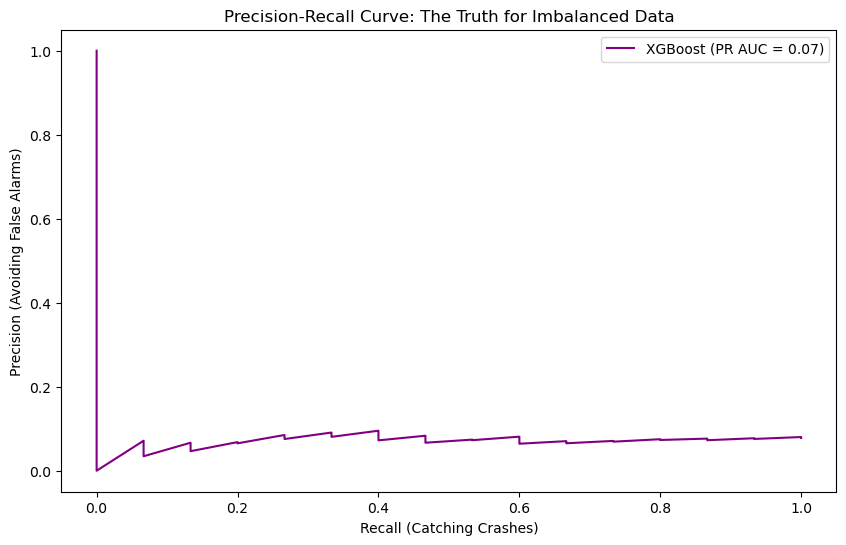

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       177
           1       0.05      0.07      0.06        15

    accuracy                           0.83       192
   macro avg       0.49      0.48      0.48       192
weighted avg       0.85      0.83      0.84       192



In [3]:
# 1. Train Final Model with Best Params
best_model = random_search.best_estimator_

# 2. Split Data (Final Hold-out Test)
# We manually split the last 20% to simulate "The Future"
split_point = int(len(X) * 0.8)
X_train_final = X.iloc[:split_point]
y_train_final = y.iloc[:split_point]
X_test_final = X.iloc[split_point:]
y_test_final = y.iloc[split_point:]

best_model.fit(X_train_final, y_train_final)

# 3. Predict
y_prob = best_model.predict_proba(X_test_final)[:, 1]
y_pred = best_model.predict(X_test_final)

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_final, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'XGBoost (PR AUC = {pr_auc:.2f})', color='purple')
plt.xlabel('Recall (Catching Crashes)')
plt.ylabel('Precision (Avoiding False Alarms)')
plt.title('Precision-Recall Curve: The Truth for Imbalanced Data')
plt.legend()
plt.show()

# 5. Classification Report
print(classification_report(y_test_final, y_pred))